# Введение

Необходимо разработать модель компьютерного зрения для сети магизинов продуктов, чтобы научиться рекомендовать релевантные товары и услуги исходя из возрастной группы клиента, а также контролировать возраст клиентов при продаже товаров с возрастными ограничениями. 

В нашем распоряжении набор фотографий реальных людей, размеченных их возрастом. 

**План работ:** 
1. Проведем исследовательский анализ данных, чтобы выбрать наиболее подходящую архитектуру модели компьютерного зрения. 
2. При необходимости, выполним аугментацию изображений.
3. Составим и обучим многослойную нейронную сеть на GPU.
4. Протестируем сеть на валидационной выборке. 

Задача представляет собой задачу регрессии. Таким образом в качестве функции потерь выберем MAE, в качестве функции активации, учитывая, что возраст не может быть отрицательным, остановимся на 'relu'

# Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from matplotlib import pyplot as plt

Выполним импорт целевых признаков и изображений. 

In [2]:
targets = pd.read_csv('/datasets/faces/labels.csv')
data_gen = ImageDataGenerator(rescale = 1./255)
data_gen_flow = data_gen.flow_from_dataframe(dataframe = targets, 
                                            directory = '/datasets/faces/final_files/',
                                            x_col = 'file_name',
                                            y_col = 'real_age',
                                            class_mode = 'raw',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            seed = 12345)

Found 7591 validated image filenames.


In [3]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В нашем распоряжении 7591 фотография с размеченным возрастом человека на снимке. 
Также, в качестве модели будем использовать предобученную модель ResNet50. 

Напечатаем гистограмму возрастов, а также сами фотографии. 

In [4]:
features, target = next(data_gen_flow)

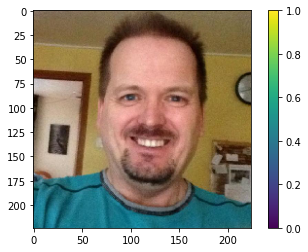

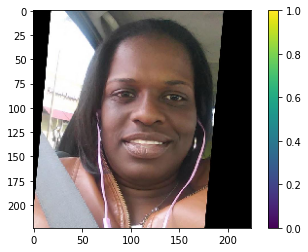

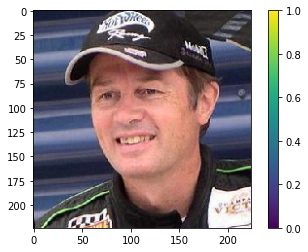

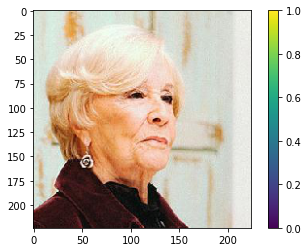

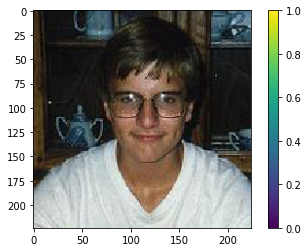

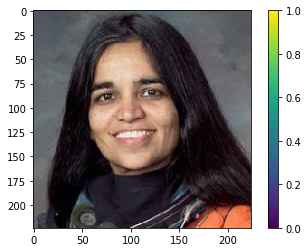

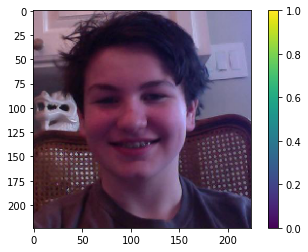

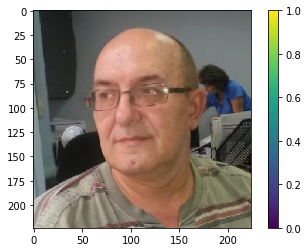

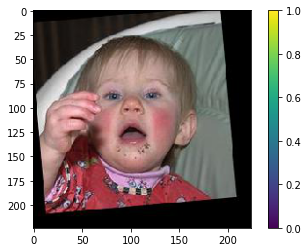

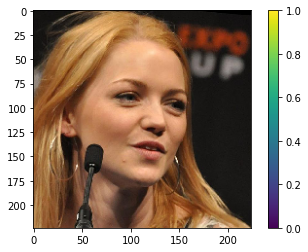

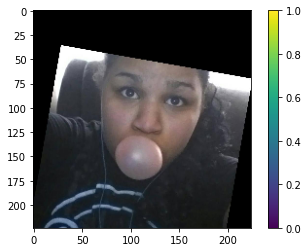

In [5]:
for i in range(0,11):
    plt.imshow(features[i])
    plt.colorbar()
    plt.show()

Видно, что представлены все расы и оба пола. Также, часть изображений повернуты на несколько градусов. 

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


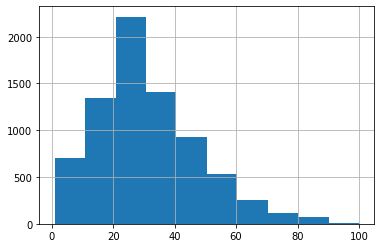

In [6]:
targets['real_age'].hist()
targets.describe()

Видно, что 75% сфотографированных людей моложе 42 лет. 
Максимальный возраст - 100 лет, минимальный - 1 год. 

# Выводы
1. Данные представляют собой 7591 фотографии людей, размеченных их реальным возрастом. 
2. Есть фотографии всех рас, полов и возрастов.
3. 75% данных составляют люди, возрастом 41 год и менее. 
4. Судя по фото, аугментация данных уже проведена, часть фото приведены под углом и смещением. 

# Обучение модели

В качестве архитектуры модели выберем ResNet50, без использования верхнего слоя. 
Добавим к существующим слоям, глобальный пулинг матрицей 2x2, а также полносвязный слой из одного нейрона, который будет возвращать итоговый прогноз по возрасту. 

В качестве оптимизатора будем использовать алгоритм Adam, в качестве функции потерь MAE, метрика также будет MAE. 

In [7]:
# -*- coding: utf-8 -*-

# -- Sheet --

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

def load_train(path):
    targets_train = pd.read_csv(path + 'labels.csv')
    data_gen = ImageDataGenerator(rescale = 1./255, validation_split=0.25)
    data_gen_flow_train = data_gen.flow_from_dataframe(dataframe=targets_train,
                                                 directory=path + '/final_files',
                                                 x_col = 'file_name',
                                                 y_col = 'real_age',
                                                 target_size = (224,224),
                                                 class_mode= 'raw',
                                                 batch_size= 32,
                                                 subset='training',
                                                 seed = 12345)
    return data_gen_flow_train

def load_test(path):
    targets_test = pd.read_csv(path + 'labels.csv')
    data_gen = ImageDataGenerator(rescale = 1./255, validation_split=0.25)
    data_gen_flow_valid = data_gen.flow_from_dataframe(dataframe=targets_test,
                                                       directory= path + '/final_files',
                                                       x_col = 'file_name',
                                                       y_col = 'real_age',
                                                       target_size=(224,224),
                                                       class_mode='raw',
                                                       batch_size=32,
                                                       subset='validation',
                                                       seed = 12345)
    return data_gen_flow_valid

def create_model(input_shape):
    optimizer = Adam(lr=0.0007)
    
    backbone = ResNet50(include_top=False,
                        input_shape=input_shape,
                        weights= 'imagenet')
    backbone.trainable = True
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation = 'relu'))

    model.compile(optimizer = optimizer, loss = 'mae', metrics= ['mae'])


    return model

def train_model(model, train_data, test_data, epochs = 20, batch_size = None, steps_per_epoch = None, validation_steps = None):
    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size,
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 2)
    return model



### Результат обучения модели.

# Выводы

В нашем распоряжении для создания модели компьютерного зрения оказались 7 300 фотографий людей всех возрастов, рас, обоих полов. Цель обучения была в том, чтобы научиться определять возраст человека по фотографии в прикассовой зоне. 

Предварительно был проведен исследовательский анализ данных, с помощью которого была выбрана оптимальная архитектура построения слоев и выбрана предобученная модель ResNet50. Также в ходе предобработки данных выяснилось отстуствие необходимости проведения аугментации изображений. 

Выранная модель обучена и готова предсказывать возраст клиентов. Точность работы модели по метрике MAE составляет 6,92. 

Для улучшения качества прогнозов потребовалось подобрать оптимальные параметры количества эпох и learning_rate алгоритма оптимизации ADAM. У меня они составили 20 и 0.0007 соответственно. 